# Neural Network สำหรับทำนายราคาน้ำมัน Brent


1. เก้า
2. กัส

## 1. Import Libraries

In [2]:
from lib_import import *
from sklearn.neural_network import MLPRegressor
#Neural Network (Multi-layer Perceptron)

lib_import.py imported successfully


## 2. Loading data and Explore data

In [3]:
df = pd.read_csv('../data/processed/merged_oil_prices.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df.head()

,date,open_x,high_x,low_x,close_x,volume_x,average_x,open_y,high_y,low_y,close_y,volume_y,average_y
0,2017-11-02,56.73,56.73,56.73,56.73,0,56.73,51.32,51.32,51.32,51.32,0,51.32
1,2017-11-03,56.84,56.84,56.84,56.84,0,56.84,51.39,51.39,51.39,51.39,0,51.39
2,2017-11-06,57.26,57.26,57.26,57.26,0,57.26,51.07,51.07,51.07,51.07,0,51.07
3,2017-11-07,57.40,57.40,57.40,57.40,0,57.40,51.43,51.43,51.43,51.43,0,51.43
4,2017-11-08,58.17,58.17,58.17,58.17,0,58.17,52.22,52.22,52.22,52.22,0,52.22


In [4]:
df.describe()

,date,open_x,high_x,low_x,close_x,volume_x,average_x,open_y,high_y,low_y,close_y,volume_y,average_y
count,1846,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000
mean,2021-07-17 19:40:14.301191680,65.546100,65.597969,65.481219,65.537378,74.929577,65.539395,60.055937,60.190195,59.891966,60.033364,890.858072,60.043776
min,2017-11-02 00:00:00,46.440000,46.440000,46.440000,46.440000,0.000000,46.440000,40.390000,40.390000,40.390000,40.390000,0.000000,40.390000
25%,2019-09-13 18:00:00,57.990000,57.990000,57.990000,57.990000,0.000000,57.990000,52.052500,52.052500,52.052500,52.052500,0.000000,52.052500
50%,2021-07-12 12:00:00,63.440000,63.440000,63.440000,63.440000,0.000000,63.440000,55.770000,55.770000,55.770000,55.770000,0.000000,55.770000
75%,2023-05-29 00:00:00,74.800000,74.975000,74.587500,74.767500,0.000000,74.796500,69.877500,70.220000,69.577500,69.877500,98.000000,69.944000
max,2025-04-03 00:00:00,83.930000,83.930000,83.930000,83.930000,11399.000000,83.930000,79.010000,79.140000,79.010000,79.010000,35933.000000,79.010000
std,NaN,9.821117,9.866789,9.767207,9.814503,572.919216,9.815091,10.131954,10.268160,9.966742,10.108302,2817.752398,10.120639


In [5]:
print('Missing:')
print(df.isnull().sum())

Missing:
date         0
open_x       0
high_x       0
low_x        0
close_x      0
volume_x     0
average_x    0
open_y       0
high_y       0
low_y        0
close_y      0
volume_y     0
average_y    0
dtype: int64


## 3. Feature Engineering

In [6]:
data = df.copy()

# Brent (close_x) เพื่อเก็บราคา 1 3 5 7 วันก่อน
for lag in [1, 3, 5, 7]:
    data[f'brent_lag_{lag}'] = data['close_x'].shift(lag)

# WTI (close_y) เพื่อเก็บราคา 1 3 5 7 วันก่อน
for lag in [1, 3, 5, 7]:
    data[f'wti_lag_{lag}'] = data['close_y'].shift(lag)

# moving average ของ brent และ WTI เพื่อหาแนวโน้มโดยเฉลี่ย 5 และ 10 วันย้อนหลัง
data['brent_ma_5'] = data['close_x'].rolling(window=5).mean()
data['brent_ma_10'] = data['close_x'].rolling(window=10).mean()
data['wti_ma_5'] = data['close_y'].rolling(window=5).mean()
data['wti_ma_10'] = data['close_y'].rolling(window=10).mean()
data['target'] = data['close_x'].shift(-1)
data_clean = data.dropna().reset_index(drop=True)

print(f'จำนวนข้อมูลหลังสร้าง features: {len(data_clean)} แถว')
print(f'จำนวน features: {len(data_clean.columns) - 2} คอลัมน์ (ไม่นับ date และ target)')
print('\nFeatures ที่สร้างขึ้น:')
feature_cols = [col for col in data_clean.columns if col not in df.columns and col != 'target']
print(feature_cols)

print(data_clean)

จำนวนข้อมูลหลังสร้าง features: 1836 แถว
จำนวน features: 24 คอลัมน์ (ไม่นับ date และ target)

Features ที่สร้างขึ้น:
['brent_lag_1', 'brent_lag_3', 'brent_lag_5', 'brent_lag_7', 'wti_lag_1', 'wti_lag_3', 'wti_lag_5', 'wti_lag_7', 'brent_ma_5', 'brent_ma_10', 'wti_ma_5', 'wti_ma_10']
           date  open_x  high_x  low_x  close_x  volume_x  average_x  open_y  \
0    2017-11-15   58.00   58.00  58.00    58.00         0     58.000   52.23   
1    2017-11-16   57.16   57.16  57.16    57.16         0     57.160   51.14   
2    2017-11-17   57.06   57.06  57.06    57.06         0     57.060   50.88   
3    2017-11-20   56.58   56.58  56.58    56.58         0     56.580   50.60   
4    2017-11-21   56.38   56.38  56.38    56.38         0     56.380   50.28   
...         ...     ...     ...    ...      ...       ...        ...     ...   
1831 2025-03-27   72.94   73.36  72.52    73.35      5545     73.083   69.15   
1832 2025-03-28   73.15   73.16  72.28    72.41      6362     72.694   69.35 

## 4. Prepare information for training

In [7]:
feature_columns = [
    # Brent features
    'close_x', 'open_x', 'high_x', 'low_x', 'average_x',
    'brent_lag_1', 'brent_lag_3', 'brent_lag_5', 'brent_lag_7',
    'brent_ma_5', 'brent_ma_10',
    # WTI features
    'close_y', 'open_y', 'high_y', 'low_y', 'average_y',
    'wti_lag_1', 'wti_lag_3', 'wti_lag_5', 'wti_lag_7',
    'wti_ma_5', 'wti_ma_10'
]   

X = data_clean[feature_columns]
y = data_clean['target']

print(f'Shape ของ X: {X.shape}')
print(f'Shape ของ y: {y.shape}')
print(f'\nจำนวน features ทั้งหมด: {X.shape[1]}')

Shape ของ X: (1836, 22)
Shape ของ y: (1836,)

จำนวน features ทั้งหมด: 22


In [8]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print('การแบ่งข้อมูล:')
print(f'Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)')
print(f'Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)')
print(f'Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)')

การแบ่งข้อมูล:
Training set: 1285 samples (70.0%)
Validation set: 275 samples (15.0%)
Test set: 276 samples (15.0%)


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print(f'Mean ของ training features หลัง scaling: {X_train_scaled.mean():.6f}')
print(f'Std ของ training features หลัง scaling: {X_train_scaled.std():.6f}')

Mean ของ training features หลัง scaling: -0.000000
Std ของ training features หลัง scaling: 1.000000


## 5. Build and Train Neural Network Model

ใช้ Multi-layer Perceptron (MLP) จาก scikit-learn

In [10]:
model = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=200,
    shuffle=True,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=10,
    verbose=True
)

# Train model
print('=' * 50)

model.fit(X_train_scaled, y_train)

print('\n' + '=' * 50)
print(f'จำนวน iterations ที่ใช้: {model.n_iter_}')
print(f'Loss สุดท้าย: {model.loss_:.4f}')

Iteration 1, loss = 1946.41560069
Validation score: -49.815784
Iteration 2, loss = 1921.09538639
Validation score: -48.986726
Iteration 3, loss = 1888.89165494
Validation score: -47.939368
Iteration 4, loss = 1848.76092650
Validation score: -46.637552
Iteration 5, loss = 1798.74340467
Validation score: -44.940038
Iteration 6, loss = 1731.80214132
Validation score: -42.849122
Iteration 7, loss = 1651.91319660
Validation score: -40.312366
Iteration 8, loss = 1550.48539769
Validation score: -37.108146
Iteration 9, loss = 1422.21690697
Validation score: -33.285561
Iteration 10, loss = 1272.28762354
Validation score: -28.957187
Iteration 11, loss = 1105.34474389
Validation score: -24.472866
Iteration 12, loss = 937.97534903
Validation score: -20.233302
Iteration 13, loss = 789.03078287
Validation score: -17.062707
Iteration 14, loss = 689.43597337
Validation score: -15.524848
Iteration 15, loss = 646.59276501
Validation score: -15.045232
Iteration 16, loss = 633.97086616
Validation score: -

## 6. Evaluate result

In [11]:
# Prediction
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

In [12]:
def calculate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'{dataset_name} Results:')
    print(f'  MSE:  ${mse:.4f}')
    print(f'  RMSE: ${rmse:.4f}')
    print(f'  MAE:  ${mae:.4f}')
    print(f'  R²:   {r2:.4f}')
    print()
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

print('=' * 50)
print('MODEL PERFORMANCE')
print('=' * 50)

train_metrics = calculate_metrics(y_train, y_train_pred, 'Training Set')
val_metrics = calculate_metrics(y_val, y_val_pred, 'Validation Set')
test_metrics = calculate_metrics(y_test, y_test_pred, 'Test Set')

results_df = pd.DataFrame({
    'Training': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
})

print('\nSummary Table:')
print(results_df)

MODEL PERFORMANCE
Training Set Results:
  MSE:  $0.7544
  RMSE: $0.8686
  MAE:  $0.6252
  R²:   0.9903

Validation Set Results:
  MSE:  $1.3196
  RMSE: $1.1487
  MAE:  $0.8930
  R²:   0.8778

Test Set Results:
  MSE:  $1.6266
  RMSE: $1.2754
  MAE:  $0.9864
  R²:   0.8545


Summary Table:
      Training  Validation      Test
MSE   0.754407    1.319610  1.626572
RMSE  0.868566    1.148743  1.275371
MAE   0.625249    0.892981  0.986408
R2    0.990329    0.877835  0.854534


## 7. Visualization

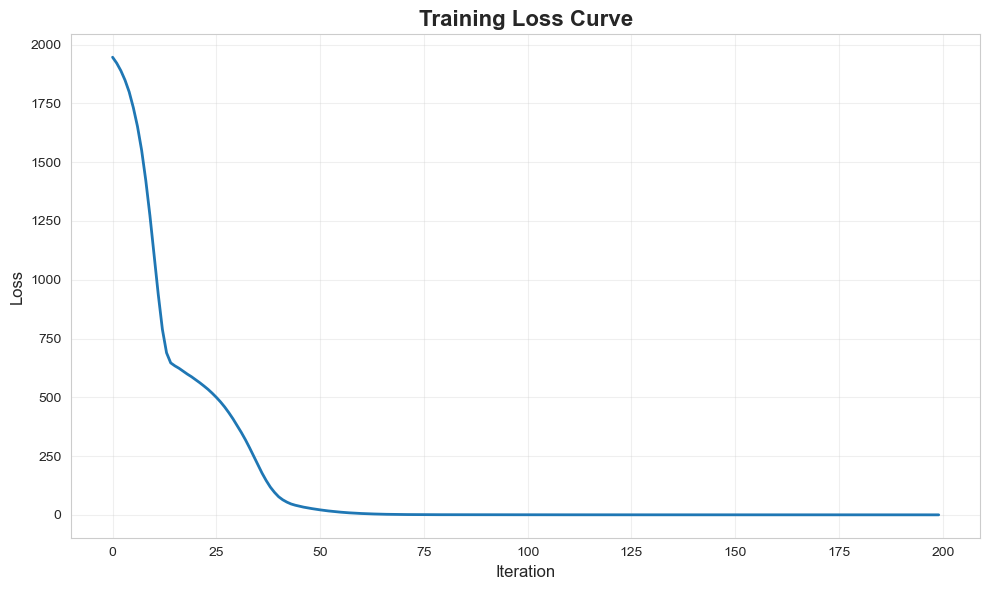

Final training loss: 0.3808


In [26]:
# Plot training curve (loss history)
plt.figure(figsize=(10, 6))
plt.plot(model.loss_curve_, linewidth=2)
plt.title('Training Loss Curve', fontsize=16, fontweight='bold')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f'Final training loss: {model.loss_:.4f}')


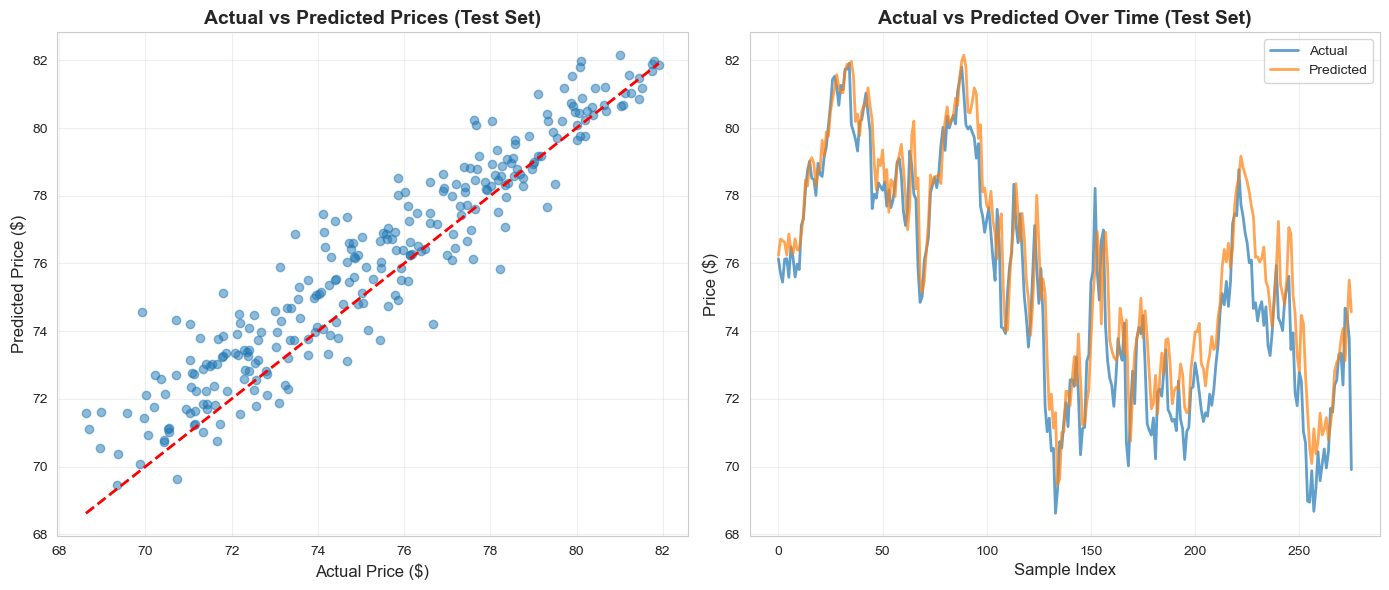

In [19]:
# Plot Actual vs Predicted สำหรับ Test Set
plt.figure(figsize=(14, 6))

# Plot 1: Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title('Actual vs Predicted Prices (Test Set)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 2: Time series plot
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test.values, label='Actual', linewidth=2, alpha=0.7)
plt.plot(range(len(y_test)), y_test_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.title('Actual vs Predicted Over Time (Test Set)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Example of prediction

In [20]:
# Example predict for 10 days
sample_size = 10
sample_df = pd.DataFrame({
    'Actual Price': y_test.values[:sample_size],
    'Predicted Price': y_test_pred[:sample_size],
    'Difference': y_test.values[:sample_size] - y_test_pred[:sample_size],
    'Error (%)': ((y_test.values[:sample_size] - y_test_pred[:sample_size]) / y_test.values[:sample_size] * 100)
})

print('=' * 50)
print(sample_df.to_string(index=True))
print('=' * 50)

   Actual Price  Predicted Price  Difference  Error (%)
0         76.14        76.235675   -0.095675  -0.125656
1         75.71        76.723534   -1.013534  -1.338706
2         75.45        76.674773   -1.224773  -1.623291
3         76.13        76.625254   -0.495254  -0.650537
4         76.14        76.245219   -0.105219  -0.138191
5         75.59        76.867229   -1.277229  -1.689680
6         76.49        76.419144    0.070856   0.092634
7         76.18        76.282064   -0.102064  -0.133978
8         75.60        76.728510   -1.128510  -1.492738
9         75.98        76.401296   -0.421296  -0.554483


## 9. Summary

In [21]:
print('=' * 50)
print('FINAL RESULTS SUMMARY')
print('=' * 50)
print(f'  MSE:  ${test_metrics["MSE"]:.4f}')
print(f'  RMSE: ${test_metrics["RMSE"]:.4f}')
print(f'  MAE:  ${test_metrics["MAE"]:.4f}')
print(f'  R²:   {test_metrics["R2"]:.4f}')
print('\n' + '=' * 50)


FINAL RESULTS SUMMARY
  MSE:  $1.6266
  RMSE: $1.2754
  MAE:  $0.9864
  R²:   0.8545



## 10. Model Performance Comparison Charts

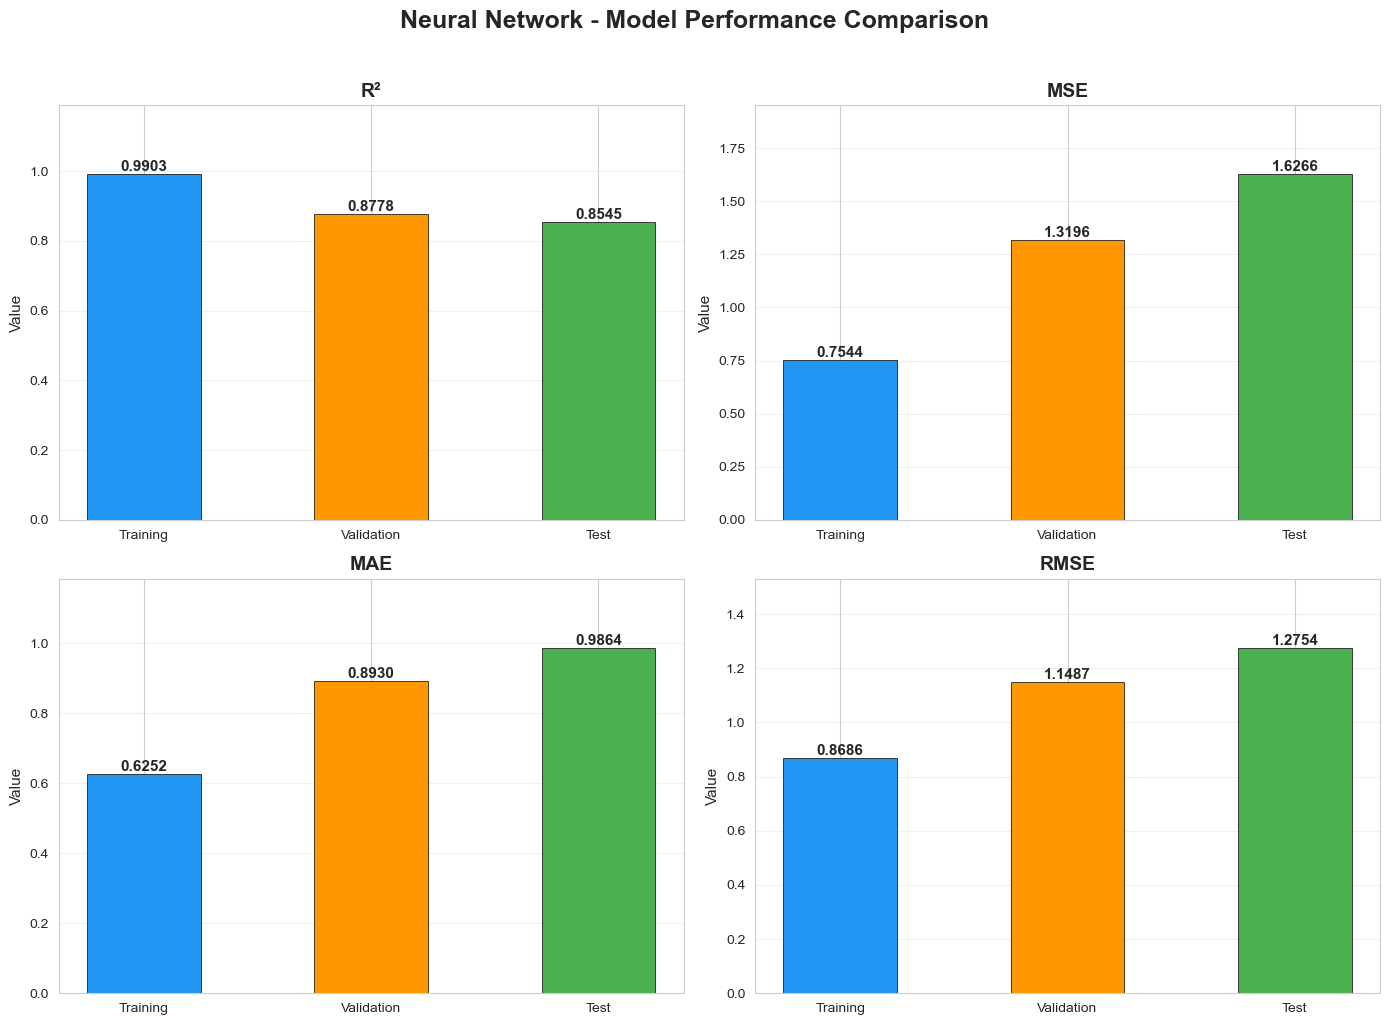

In [22]:
metrics_names = ['R²', 'MSE', 'MAE', 'RMSE']
metrics_keys = ['R2', 'MSE', 'MAE', 'RMSE']

train_values = [train_metrics[k] for k in metrics_keys]
val_values = [val_metrics[k] for k in metrics_keys]
test_values = [test_metrics[k] for k in metrics_keys]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Neural Network - Model Performance Comparison', fontsize=18, fontweight='bold', y=1.02)

colors = ['#2196F3', '#FF9800', '#4CAF50']
labels = ['Training', 'Validation', 'Test']

for idx, (ax, name, key) in enumerate(zip(axes.flat, metrics_names, metrics_keys)):
    values = [train_metrics[key], val_metrics[key], test_metrics[key]]
    bars = ax.bar(labels, values, color=colors, edgecolor='black', linewidth=0.5, width=0.5)

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_ylabel('Value', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, max(values) * 1.2)

plt.tight_layout()
plt.show()
